<a href="https://colab.research.google.com/github/YoungGaLee/AI_Study/blob/master/jung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.init 
import math
import numpy

data_parameter = 6
hidden_week_dim = 7
hidden_weekend_dim = 6
output_dim = 1 
learning_rate = 0.01
iterations = 1000


train_data = pd.read_csv('./jung_train.csv', usecols=['rainfall_all','maxtemp_all',
                        'avgtemp_all','sensible_all','GDP','max_power'])
trainxy_data = train_data.values
train_set = trainxy_data #1827 : 2019.1.1 추가해서 떨어지게 변경



train_set_np = np.array(train_set)
change = np.reshape(train_set_np,(261,7,data_parameter)) #1827x5 >> 261x7x5 로 변경
#print(change.shape) # (261, 7, 5)
#print(change[0]) # 2014/1/1~2014/1/7 : 수요일


# 수 목 금 토 일 월 화 [3],[4]
weekend = change[:, 3:5,:] # 토~일 자르기
#print(weekend[0])


sat = np.delete(change,3,axis=1)
week = np.delete(sat,3,axis=1)#수~화
#print(week[0])


#print(week[0],"수~화인지 확인(4,5주말제외)")
#print(weekend[0],"토 일인지 확인") # ㅇㅇ 토일맞음

WEEK = np.reshape(week,(1305,data_parameter)) #사이즈변형 
WEEKEND = np.reshape(weekend,(522,data_parameter)) # 사이즈변형

#======================================================================================
test_data = pd.read_csv('./jung_test_first.csv', usecols=['rainfall_all','maxtemp_all', 
                        'avgtemp_all','sensible_all','GDP','max_power'])
testxy_data = test_data.values
test_set = testxy_data  # (365, 5) > 365 / 7 = 52 ...1

test_set_np = np.array(test_set)

change_test = np.reshape(test_set_np,(53,7,data_parameter)) #364x5 >> 52x7x5 로 변경
#print(change_test[0]) # 2014/1/1~2014/1/7 : 화~월 

weekend_test = change_test[:, 3:5,:] # 토~일 자르기

sat = np.delete(change_test,3,axis=1)
week_test = np.delete(sat,3,axis=1)#수~화


#print(week_test[0],"수~화인지 확인(4,5주말제외)")
#print(weekend_test[0],"토 일인지 확인") # ㅇㅇ 토일맞음

WEEK_test = np.reshape(week_test,(265,data_parameter)) #사이즈변형 
WEEKEND_test = np.reshape(weekend_test,(106,data_parameter)) # 사이즈변형
#=================================================



device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)


class Power_week(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Power_week, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
            # torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc_cnn = torch.nn.Linear(64, 5, bias=True)
        torch.nn.init.xavier_uniform_(self.fc_cnn.weight)

        self.LSTM = torch.nn.LSTM(input_dim, hidden_week_dim, num_layers=layers, batch_first=True) 
        self.fc_rnn = torch.nn.Linear(hidden_week_dim, output_dim, bias=True) 

    def forward(self, x):
        x = torch.unsqueeze(x,1)
        w,h = x.shape[2],x.shape[3] 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc_cnn(out)
        out = torch.unsqueeze(out,-1)
        x, _status = self.LSTM(out) 
        x = self.fc_rnn(x[:, -1])
        return x



class Power_weekend(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Power_weekend, self).__init__() #****************************
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=1), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=2, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc_cnn = torch.nn.Linear(64, 2, bias=True)
        torch.nn.init.xavier_uniform_(self.fc_cnn.weight)

        self.LSTM = torch.nn.LSTM(input_dim, hidden_weekend_dim, num_layers=layers, batch_first=True) 
        self.fc_rnn = torch.nn.Linear(hidden_weekend_dim, output_dim, bias=True) 

    def forward(self, x):
        x = torch.unsqueeze(x,1)
        w,h = x.shape[2],x.shape[3]       
        out = self.layer1(x)        
        out = self.layer2(out)       
        out = self.layer3(out)       
        out = out.view(out.size(0), -1) 
        out = self.fc_cnn(out)
        out = torch.unsqueeze(out,-1)
        
        x, _status = self.LSTM(out) 
        x = self.fc_rnn(x[:, -1])
        
        return x




def build_dataset_week(time_series):
  #print(time_series.shape,"지금") # (1305,5)
  seq_length = 5
  dataX = []
  dataY = []
  for i in range(0, len(time_series)-seq_length): 
    _x = time_series[i:i + seq_length, :-1] #(5,4)
    #_x[0] : 2014.1.1~5 / 네개요소
    _y = time_series[i+seq_length,-1]
    #_y[0] : 2014.1.8 / 최대전력량

#이렇게 그냥 학습시키면 12/25~12/31까지 학습시켜서 1/1예측한 거 까지 학습시키고 끝나는 형태임.
#심지어 test는 2019.1.8부터 예측됨.(카톡사진) : (1/2~7은 예측 안시키고 있음)1/2예측하려면 12/26(수)부터 값 들어가야 함.*********(수정)
    
    dataX.append(_x)
    dataY.append(_y)
    
  
  return np.array(dataX), np.array(dataY) 

def build_dataset_weekend(time_series):
  #print(time_series[0],"지금") #522 5
  seq_length = 2
  dataX = []
  dataY = []

  for i in range(0, len(time_series)-seq_length): # 520번
    _x = time_series[i:i + seq_length, :-1] 
    #print(_x.shape,"_x") #(2,4) : 2014.1.6~7    >>잘 안되면 (4,4)로 바꾸기
    #print(_x[0],"_x[0]")
    _y = time_series[i+seq_length, -1] 
    #print(_y.size,"_y") #[0] : 2014.1.13
    
    dataX.append(_x)
    dataY.append(_y)
    
  return np.array(dataX), np.array(dataY) 

def build_dataset(time_series):
  seq_length = 7
  dataX = []
  dataY = []
  for i in range(0, len(time_series)-seq_length): 
    _x = time_series[i:i + seq_length, :-1] 

    _y = time_series[i+seq_length, [-1]] 
    
    dataX.append(_x)
    dataY.append(_y)
    
  return np.array(dataX), np.array(dataY) 


trainX_week, trainY_week = build_dataset_week(WEEK)


trainX_weekend, trainY_weekend = build_dataset_weekend(WEEKEND)


testX_week, testY_week = build_dataset_week(WEEK_test)
testX_weekend, testY_weekend = build_dataset_weekend(WEEKEND_test)

testX ,testY = build_dataset(change_test)


#==================================================================

train_x_week_numerator = trainX_week - np.min(trainX_week, 0) 
train_x_week_denominator = np.max(trainX_week, 0) - np.min(trainX_week, 0)
train_x_week_set = train_x_week_numerator / (train_x_week_denominator + 1e-7)

train_y_week_numerator = trainY_week - np.min(trainY_week, 0) 
train_y_week_denominator = np.max(trainY_week, 0) - np.min(trainY_week, 0)
train_y_week_set = train_y_week_numerator / (train_y_week_denominator + 1e-7)


train_x_weekend_numerator = trainX_weekend - np.min(trainX_weekend, 0) 
train_x_weekend_denominator = np.max(trainX_weekend, 0) - np.min(trainX_weekend, 0)
train_x_weekend_set = train_x_weekend_numerator / (train_x_weekend_denominator + 1e-7)

train_y_weekend_numerator = trainY_weekend - np.min(trainY_weekend, 0) 
train_y_weekend_denominator = np.max(trainY_weekend, 0) - np.min(trainY_weekend, 0)
train_y_weekend_set = train_y_weekend_numerator / (train_y_weekend_denominator + 1e-7)

test_x_week_numerator = testX_week - np.min(testX_week, 0) 
test_x_week_denominator = np.max(testX_week, 0) - np.min(testX_week, 0)
test_x_week_set = test_x_week_numerator / (test_x_week_denominator + 1e-7)

test_y_week_numerator = testY_week - np.min(testY_week, 0) 
test_y_week_denominator = np.max(testY_week, 0) - np.min(testY_week, 0)
test_y_week_set = test_y_week_numerator / (test_y_week_denominator + 1e-7)

test_x_weekend_numerator = testX_weekend - np.min(testX_weekend, 0) 
test_x_weekend_denominator = np.max(testX_weekend, 0) - np.min(testX_weekend, 0)
test_x_weekend_set = test_x_weekend_numerator / (test_x_weekend_denominator + 1e-7)

test_y_weekend_numerator = testY_weekend - np.min(testY_weekend, 0) 
test_y_weekend_denominator = np.max(testY_weekend, 0) - np.min(testY_weekend, 0)
test_y_weekend_set = test_y_weekend_numerator / (test_y_weekend_denominator + 1e-7)


trainX_week_tensor = torch.FloatTensor(train_x_week_set) 
trainY_week_tensor = torch.FloatTensor(train_y_week_set)

trainX_weekend_tensor = torch.FloatTensor(train_x_weekend_set) 
trainY_weekend_tensor = torch.FloatTensor(train_y_weekend_set)

testX_week_tensor = torch.FloatTensor(test_x_week_set)
testY_week_tensor = torch.FloatTensor(test_y_week_set)

testX_weekend_tensor = torch.FloatTensor(test_x_weekend_set)
testY_weekend_tensor = torch.FloatTensor(test_y_weekend_set)


testY_tensor = torch.FloatTensor(testY)


Power_week_prediction = Power_week(1, hidden_week_dim, output_dim, 1)
Power_weekend_prediction = Power_weekend(1, hidden_weekend_dim, output_dim, 1)

criterion = torch.nn.MSELoss() 

week_optimizer = optim.Adam(Power_week_prediction.parameters(), lr=learning_rate) 
weekend_optimizer = optim.Adam(Power_weekend_prediction.parameters(), lr=learning_rate)




[[ 0.00000000e+00  2.68184458e+00  5.28086000e+03  8.72319161e+00
   2.21250950e+00]
 [ 0.00000000e+00  4.14355974e+00  5.28086000e+03  9.84227030e+00
   3.34589706e+00]
 [ 1.29750587e+00  3.66537507e+00  5.28086000e+03  6.18051961e+00
   2.67604733e+00]
 [ 0.00000000e+00  4.71502370e-01  5.28086000e+03  4.92140109e+00
  -1.46494525e+00]
 [ 7.65833796e-01  4.84866641e+00  5.28086000e+03  9.24048096e+00
   4.01917260e+00]] 어디까지인가 12월 24일이면 성공


In [ ]:

for i in range(iterations+1): 
    X = trainX_week_tensor
    Y = trainY_week_tensor
    
    week_optimizer.zero_grad()
    outputs = Power_week_prediction(X)
    outputs = torch.squeeze(outputs,dim=1)

    loss = criterion(outputs, Y) # 실제오차보다 너무 작아서 MSE > RMSE로 일단 표시 #실제 오차 아님.
    loss.backward() 
    week_optimizer.step()
    if i % 100 == 0 :
      print(i, "loss: ", loss.item()) 
first = outputs[-1]


0 loss:  0.0908103808760643
100 loss:  0.006955509074032307
200 loss:  0.00592844607308507
300 loss:  0.005174001678824425
400 loss:  0.004258645698428154
500 loss:  0.004452893044799566
600 loss:  0.0031753983348608017
700 loss:  0.0023335071746259928
800 loss:  0.002030255738645792
900 loss:  0.001499979174695909
1000 loss:  0.0024188882671296597


In [ ]:

for i in range(iterations+1): 
    X_ = trainX_weekend_tensor
    Y_ = trainY_weekend_tensor
    
    weekend_optimizer.zero_grad()
    outputs_ = Power_weekend_prediction(X_)
    outputs_ = torch.squeeze(outputs_,dim=1)

    loss_ = criterion(outputs_, Y_) # 실제오차보다 너무 작아서 MSE > RMSE로 일단 표시 #실제 오차 아님.
    loss_.backward() 
    weekend_optimizer.step()
    if i % 100 == 0 :
      print(i, "loss: ", loss_.item()) 



0 loss:  0.030974652618169785
100 loss:  0.008645223453640938
200 loss:  0.00787623506039381
300 loss:  0.007030497305095196
400 loss:  0.006362091284245253
500 loss:  0.00510779395699501
600 loss:  0.006058547180145979
700 loss:  0.004797611851245165
800 loss:  0.004523362033069134
900 loss:  0.005428491160273552
1000 loss:  0.002824455499649048


(260,) aasfasdfasdf
(104,) aasfasdfasdf
============평일============
5.610560380600217
tensor(0.1388)
============주말============
7.598340136363296
tensor(0.2540)
============ 결론 ============
6.178497453675382
============= 1월 1일 ===============
tensor(67696.9297)
============평일============


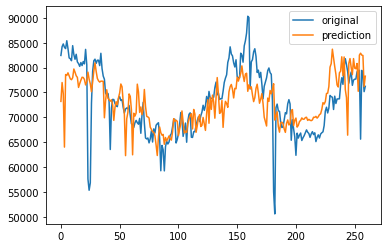

============주말============


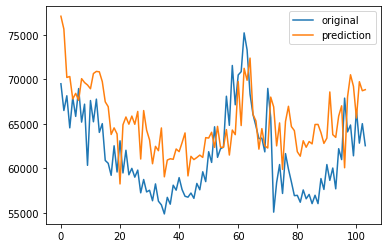

In [30]:


with torch.no_grad():
    prediction_week = Power_week_prediction(testX_week_tensor)
    prediction_week = torch.squeeze(prediction_week,dim=-1)
    prediction_powerV_week = prediction_week *(test_y_week_denominator + 1e-7) + np.min(testY_week, 0) #실제 전력예측량(365)
    First = first *(test_y_week_denominator + 1e-7) + np.min(testY_week, 0)

    prediction_weekend = Power_weekend_prediction(testX_weekend_tensor)
    prediction_weekend = torch.squeeze(prediction_weekend,dim=-1)
    prediction_powerV_weekend = prediction_weekend *(test_y_weekend_denominator + 1e-7) + np.min(testY_weekend, 0) #실제 전력예측량(365)
    
    #RMSE, MAPE는 분기별
    MSE = torch.nn.MSELoss() 
    

    #예측값 4분기
    part_week_1 = prediction_powerV_week[:90]
    part_week_2 = prediction_powerV_week[90:181]
    part_week_3 = prediction_powerV_week[181:273]
    part_week_4 = prediction_powerV_week[273:]
    
    #예측값_정규화
    part_week_n_1 = prediction_week[:90]
    part_week_n_2 = prediction_week[90:181]
    part_week_n_3 = prediction_week[181:273]
    part_week_n_4 = prediction_week[273:]


    #실제값 4분기
    Y_week_1 = testY_week[:90]
    Y_week_2 = testY_week[90:181]
    Y_week_3 = testY_week[181:273]
    Y_week_4 = testY_week[273:]
    
    #실제값_정규화
    Y_week_tensor_1 = testY_week_tensor[:90]
    Y_week_tensor_2 = testY_week_tensor[90:181]
    Y_week_tensor_3 = testY_week_tensor[181:273]
    Y_week_tensor_4 = testY_week_tensor[273:]
    

    MSE_week_whole = MSE(testY_week_tensor,prediction_week)
    MSE_week_1 = MSE(Y_week_tensor_1,part_week_n_1) # 실제:실제값
    MSE_week_2 = MSE(Y_week_tensor_2,part_week_n_2)
    MSE_week_3 = MSE(Y_week_tensor_3,part_week_n_3)
    MSE_week_4 = MSE(Y_week_tensor_4,part_week_n_4)


    
    RMSE_week_whole = torch.sqrt(MSE_week_whole) #나눠준 후 루트
    RMSE_week_1 = torch.sqrt(MSE_week_1)
    RMSE_week_2 = torch.sqrt(MSE_week_2)
    RMSE_week_3 = torch.sqrt(MSE_week_3)
    RMSE_week_4 = torch.sqrt(MSE_week_4)



    MAPE_week_whole =  np.mean(np.abs((testY_week - prediction_powerV_week.numpy()) / testY_week)) * 100
    MAPE_week_1 =  np.mean(np.abs((Y_week_1 - part_week_1.numpy()) / Y_week_1)) * 100
    #MAPE_week_2 =  np.mean(np.abs((Y_week_2 - part_week_2.numpy()) / Y_week_2)) * 100
    #MAPE_week_3 =  np.mean(np.abs((Y_week_3 - part_week_3.numpy()) / Y_week_3)) * 100
    #MAPE_week_4 =  np.mean(np.abs((Y_week_4 - part_week_4.numpy()) / Y_week_4)) * 100



#===========================================================================================

    #예측값 4분기
    part_weekend_1 = prediction_powerV_weekend[:90]
    part_weekend_2 = prediction_powerV_weekend[90:181]
    part_weekend_3 = prediction_powerV_weekend[181:273]
    part_weekend_4 = prediction_powerV_weekend[273:]
    
    #예측값_정규화
    part_weekend_n_1 = prediction_weekend[:90]
    part_weekend_n_2 = prediction_weekend[90:181]
    part_weekend_n_3 = prediction_weekend[181:273]
    part_weekend_n_4 = prediction_weekend[273:]


    #실제값 4분기
    Y_weekend_1 = testY_weekend[:90]
    Y_weekend_2 = testY_weekend[90:181]
    Y_weekend_3 = testY_weekend[181:273]
    Y_weekend_4 = testY_weekend[273:]
    
    #실제값_정규화
    Y_weekend_tensor_1 = testY_weekend_tensor[:90]
    Y_weekend_tensor_2 = testY_weekend_tensor[90:181]
    Y_weekend_tensor_3 = testY_weekend_tensor[181:273]
    Y_weekend_tensor_4 = testY_weekend_tensor[273:]
    

    MSE_weekend_whole = MSE(testY_weekend_tensor,prediction_weekend)
    MSE_weekend_1 = MSE(Y_weekend_tensor_1,part_weekend_n_1) # 실제:실제값
    MSE_weekend_2 = MSE(Y_weekend_tensor_2,part_weekend_n_2)
    MSE_weekend_3 = MSE(Y_weekend_tensor_3,part_weekend_n_3)
    MSE_weekend_4 = MSE(Y_weekend_tensor_4,part_weekend_n_4)


    
    RMSE_weekend_whole = torch.sqrt(MSE_weekend_whole) #나눠준 후 루트
    RMSE_weekend_1 = torch.sqrt(MSE_weekend_1)
    RMSE_weekend_2 = torch.sqrt(MSE_weekend_2)
    RMSE_weekend_3 = torch.sqrt(MSE_weekend_3)
    RMSE_weekend_4 = torch.sqrt(MSE_weekend_4)



    MAPE_weekend_whole =  np.mean(np.abs((testY_weekend - prediction_powerV_weekend.numpy()) / testY_weekend)) * 100
    MAPE_weekend_1 =  np.mean(np.abs((Y_weekend_1 - part_weekend_1.numpy()) / Y_weekend_1)) * 100
    MAPE_weekend_2 =  np.mean(np.abs((Y_weekend_2 - part_weekend_2.numpy()) / Y_weekend_2)) * 100
    #MAPE_weekend_3 =  np.mean(np.abs((Y_weekend_3 - part_weekend_3.numpy()) / Y_weekend_3)) * 100
    #MAPE_weekend_4 =  np.mean(np.abs((Y_weekend_4 - part_weekend_4.numpy()) / Y_weekend_4)) * 100


    #========================================================


    #========================================================

    print('============평일============')
    print(MAPE_week_whole)
    print(RMSE_week_whole)

    print('============주말============')
    print(MAPE_weekend_whole)
    print(RMSE_weekend_whole)




print('============ 결론 ============')
final = (MAPE_week_whole*260 + MAPE_weekend_whole*104)/364
print(final)


print("============= 1월 1일 ===============")
print(First)



print('============평일============')
plt.plot(testY_week)
plt.plot(prediction_powerV_week.data.numpy())
plt.legend(['original', 'prediction'])
plt.show()
print('============주말============')
plt.plot(testY_weekend)
plt.plot(prediction_powerV_weekend.data.numpy())
plt.legend(['original', 'prediction'])
plt.show()


df1 = pd.DataFrame([[MAPE_week_whole],[RMSE_week_whole]])
df2 = pd.DataFrame(testY_week) 
df3 = pd.DataFrame(prediction_powerV_week)
df1.to_excel('평일_W.xlsx', index=False)
df2.to_excel('평일_y.xlsx', index=False)
df3.to_excel('평일_pred.xlsx', index=False)

df4 = pd.DataFrame([[MAPE_weekend_whole],[RMSE_weekend_whole]])
df5 = pd.DataFrame(testY_weekend) 
df6 = pd.DataFrame(prediction_powerV_weekend)
df4.to_excel('주말_W.xlsx', index=False)
df5.to_excel('주말_y.xlsx', index=False)
df6.to_excel('주말_pred.xlsx', index=False)